# **12. Algoritmo SWAP Test**

# **Dive in Learning**

# ***Diplomado en Computación y Programación Cuántica***

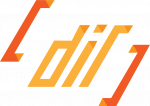

# SWAP Test

Este algoritmo nos sirve para comparar dos estados, obtener fidelidad entre estados, obtener cuan puro es un estado, entre otras aplicaciones como métrica de distancia.

In [1]:
!pip install qiskit --quiet
!pip install qiskit[visualization] --quiet
!pip install qiskit_aer --quiet
!pip install matplotlib --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 117.3 MB/s eta 0:00:00


### Bibliotecas a utilizar

In [2]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from qiskit import *
from qiskit.circuit.library import RYGate
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Comparar Imágenes

Para comparar imágenes la debemos transformar a escala de grises y a un vector, por ejemplo:

In [4]:
im_pico = Image.open("/content/drive/MyDrive/Diplomado_Cómputo_y_Programación_Cuántica/SwapTest/Recursos/Imagenes/4x4/pickaxe1.png").convert("L")
im_espada = Image.open("/content/drive/MyDrive/Diplomado_Cómputo_y_Programación_Cuántica/SwapTest/Recursos/Imagenes/4x4/sword1.png").convert("L")

De esta forma se extraen los valores de las matrices en forma de vector, se aplanan o estiran las imágenes

In [5]:
print (im_pico.size)
print (im_espada.size)

(4, 4)
(4, 4)


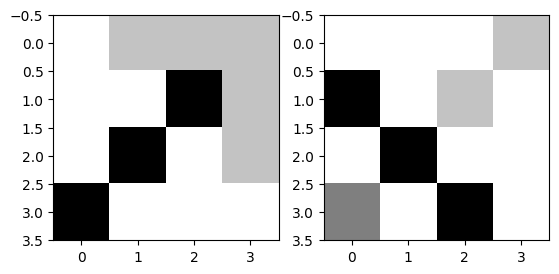

In [6]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(im_pico, cmap='gray')
ax[1].imshow(im_espada, cmap='gray')

## Forma clásica de comparación

En la actualidad, existen diversas métricas de comparación, entre las cuales por su simplicidad se suele utilizar la distancia euclideana normalizada para saber que tan parecidos son dos vectores, donde para cada valor en la posición $x$ se compara de la siguiente forma:

$\Large similitud_{x} = 1 - \frac{|v1_{x}-v2_{x}|}{v_{max}-v_{min}}$

Y la similitud entre dos vectores de tamaño $N$ será:

$\Large similitud = \frac{\sum_{x=0}^{N-1} similitud_{x}} {N} = \frac{\sum_{x=0}^{N-1} \frac{|v1_{x}-v2_{x}|}{v_{max}-v_{min}}} {N}$

In [7]:
v_pico = np.array(im_pico).reshape(im_pico.size[0]*im_pico.size[1])
v_espada = np.array(im_espada).reshape(im_espada.size[0]*im_espada.size[1])
print("Vector de imagen de pico: \n\t", v_pico)
print("Vector de imagen de espada: \n\t", v_espada)

Vector de imagen de pico: 
	 [255 195 195 195 255 255   0 195 255   0 255 195   0 255 255 255]
Vector de imagen de espada: 
	 [255 255 255 195   0 255 195 255 255   0 255 255 127 255   0 255]


In [8]:
def obtenerSimilitud(vector1, vector2):
    similitud = 0
    for pixel_v1, pixel_v2 in zip(vector1, vector2):
        similitud += abs(int(pixel_v1)-int(pixel_v2))/255 # El cast o palabra int refiere a convertir el tipo de dato que va de 0-255 a un dato que pueda tomar valores negativos
    return 1 - similitud / len(vector1) # Se debe restar a 1, dado que entre más cercano a 0 sea la distancia euclideana, más parecido es

print(f"El pico se parece {obtenerSimilitud(v_pico, v_espada)*100:.4f}% a la espada")


El pico se parece 73.7255% a la espada


## SWAP Test para comparar vectores

Este algoritmo nos permite comparar dos estados cuánticos $\psi$ y $\phi$, dando como resultado el producto interior entre ambos estados:

$$\Large similitud = |\langle \psi|\phi\rangle|^2 $$

donde cada estado representa un vector y según sea la codificación, entregará una métrica de similitud con valores entre 0 y 1, acorde a cuanto se parece.

Para el caso presentado, la métrica entregada es el promedio de la distancia coseno entre los diferentes pixeles, tomando en cuenta que cada valor de pixel se transformará de un rango de 0-255 a uno nuevo de 0-$\pi$. Con lo que los nuevos valores de cada vector y la similitud para este caso se define como:

$$\Large\theta_x = \pi\frac{v1_x}{255}, \hspace{30pt} \varphi_x = \pi\frac{v2_x}{255}$$

<br>

$$\Large similitud = \left(  \frac{\sum_{x=0}^{N-1}\cos\left( \frac{\theta_x - \varphi_x}{2} \right)}{N}  \right)^2$$

El algoritmo es el siguiente:

![image](./Recursos/Vectores/SWAPTest_Algoritmo.svg)

Y las mediciones entregadas por este algoritmo siguen la siguiente fórmula de probabilidad de medir el estado 0:

$$\Large Pr(0) = \frac{1}{2} + \frac{1}{2}\left(  \frac{\sum_{x=0}^{N-1}\cos\left( \frac{\theta_x - \varphi_x}{2} \right)}{N}  \right)^2$$

### Propuesta de inicialización de datos de imágenes en estado cuántico

Existen muchas formas de inicializar una imagen en un estado cuántico, pero en esta ocasión se propone el uso de una QRAM con compuertas $R_y$

NOTA: No es un circuito optimizado, solo para fines didácticos

In [9]:
def inicializar_vector(vector):
    N = len(vector)

    n_qubits = int(np.ceil(np.log2(N)))

    pos_reg = QuantumRegister(n_qubits, 'posiciones')
    data_reg = QuantumRegister(1, 'Data')

    qc = QuantumCircuit(pos_reg, data_reg)

    qc.h(pos_reg)

    for i in range(N):

        # 'Seleccionamos' la posición deseada, si existe 'X' es un '0'
        # Ejemplo: 3, en binario 0011, en compuertas 'X X I I'
        for j in range(n_qubits):
            if (i>>j) & 1 == 0:
                qc.x(j)
        qc.append(   RYGate(np.pi*(vector[i]/255)).control(n_qubits), pos_reg[:] + data_reg[:]   )

        # Revertimos la selección
        for j in range(n_qubits):
            if (i>>j) & 1 == 0:
                qc.x(j)
        qc.barrier()

    return n_qubits, qc

Ejemplo de circuito con vector de espada: 
	


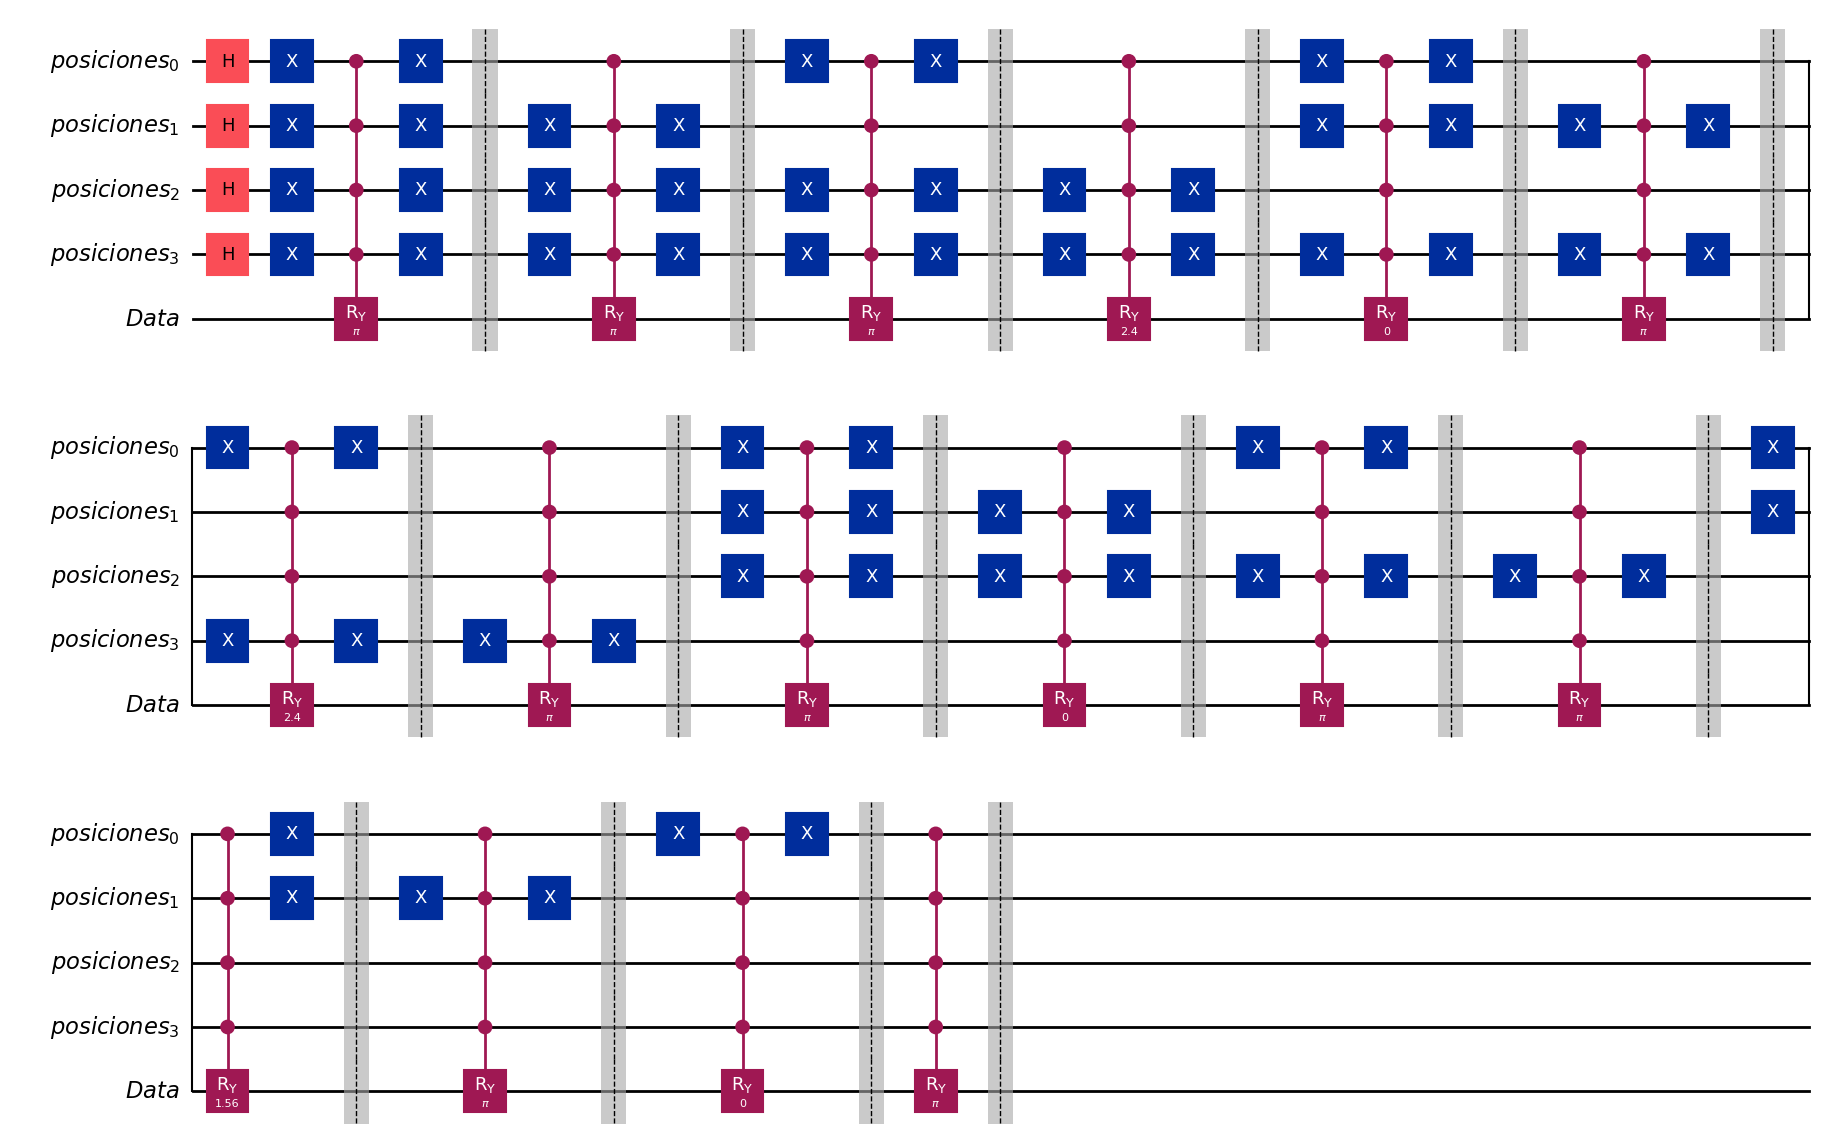

In [10]:
print("Ejemplo de circuito con vector de espada: \n\t")
inicializar_vector(v_espada)[1].draw("mpl")

### Algoritmo completo

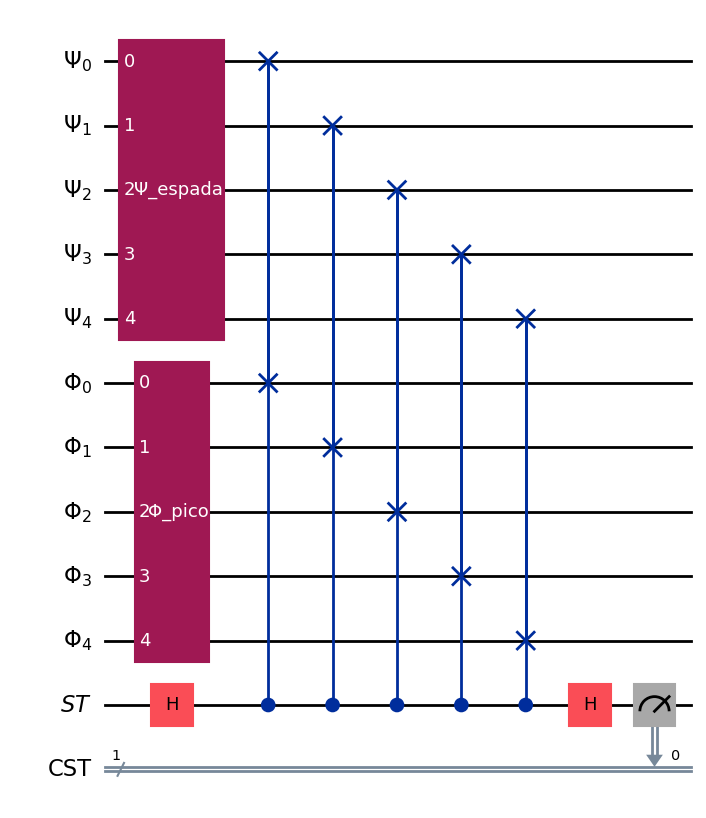

In [11]:
n_qubits_espada, U_espada = inicializar_vector(v_espada)
U_espada.name = 'Ψ_espada'
n_qubits_pico, U_pico = inicializar_vector(v_pico)
U_pico.name = 'Φ_pico'
psi_register = QuantumRegister(n_qubits_espada + 1, 'Ψ')
phi_register = QuantumRegister(n_qubits_pico + 1, 'Φ')
st_register = QuantumRegister(1, 'ST')
cst_register = ClassicalRegister(1, 'CST')
qc = QuantumCircuit(psi_register, phi_register, st_register, cst_register)
qc.append(U_espada, psi_register)
qc.append(U_pico, phi_register)
qc.h(st_register)
for i in range(n_qubits_espada+1):
    qc.cswap(st_register, psi_register[i], phi_register[i])
qc.h(st_register)
qc.measure(st_register, cst_register)
qc.draw("mpl")

### Ejecución del algoritmo

El pico se parece 63.8611% a la espada


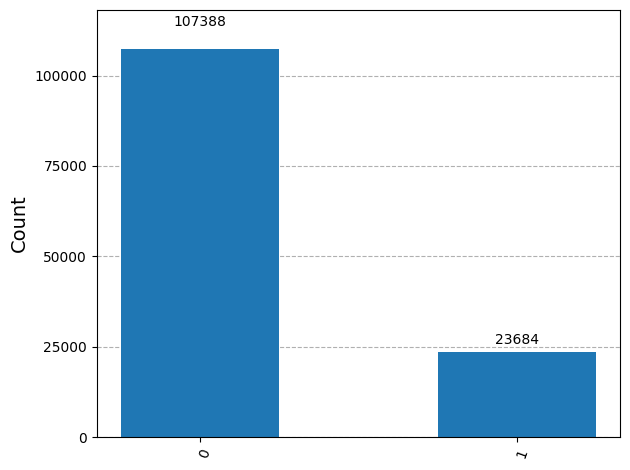

In [12]:
n_experimentos = 2**17
backend = Aer.get_backend("statevector_simulator")
transpilation = transpile(qc, backend)
# display(transpilation.draw("mpl"))
job = backend.run(transpilation, shots=n_experimentos)
result = job.result()
counts = result.get_counts()

similitud = 2*counts['0']/n_experimentos - 1
print(f"El pico se parece {similitud*100:.4f}% a la espada")
display(plot_histogram(counts))